# NeuroBook

In [99]:
%pip install mne

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [100]:
import mne
import numpy as np
import pandas as pd

## Data Loading and Inspection 

In [101]:
path = '../Datasets/EEG_data.csv'
input= pd.read_csv(path)
input.info()
input

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1149 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1144), int64(1), object(4)
memory usage: 8.3+ MB


,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [102]:
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}

## Data Loading and Inspection 

In [103]:
input.describe()

,no.,age,education,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
count,945.000000,945.000000,930.000000,932.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,...,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,473.000000,30.594804,13.438710,101.580472,20.182936,21.177584,17.749553,18.901698,20.447079,19.490329,...,75.889633,55.049113,56.959796,60.739169,69.829254,47.862489,66.832798,39.301406,66.153213,57.056207
std,272.942302,11.781592,2.550461,17.022414,11.282022,12.230662,10.003598,9.079482,9.742912,9.252500,...,15.861641,19.541956,18.326785,18.052887,17.725321,19.685722,17.028701,20.790933,18.088548,19.600107
min,1.000000,18.000000,0.000000,49.000000,3.272260,3.244199,3.050507,3.412618,5.066593,4.048931,...,12.611954,0.519048,6.926792,0.708008,2.421748,0.036664,1.032207,1.228502,0.363268,3.988805
25%,237.000000,21.730000,12.000000,91.000000,12.784872,13.019269,11.134327,12.460586,13.548645,12.637717,...,68.014443,41.607506,43.682444,48.374883,58.937785,32.581046,55.872070,22.049743,54.710605,43.955229
50%,473.000000,26.150000,13.000000,102.000000,17.065286,17.838251,15.541469,16.733004,18.065276,17.432568,...,78.647712,55.158858,56.657348,61.257972,72.298636,45.719426,68.238375,36.549938,67.988937,57.515871
75%,709.000000,35.450000,16.000000,114.000000,24.492760,25.654394,21.623961,23.347900,25.573096,23.956748,...,87.398387,69.740640,70.649245,73.979100,83.066877,62.081839,79.192418,54.169209,79.527764,71.626382
max,945.000000,71.880000,20.000000,145.000000,92.826192,101.515687,91.373456,82.544167,101.566662,77.197502,...,99.678649,100.000000,99.307895,100.000000,99.581629,98.720067,99.650154,98.413320,100.000000,99.287092


## Cleaning and Preprocessing

In [104]:
ptsd = input[input['specific.disorder'] == 'Posttraumatic stress disorder']
hc = input[input['specific.disorder'] == 'Healthy control'].sample(n=52, random_state=42)
data = pd.concat([ptsd, hc])
data

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
297,298,F,36.62,2011.1.28,12.0,99.0,Trauma and stress related disorder,Posttraumatic stress disorder,17.603385,17.243334,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
309,310,F,55.21,2012.4.9,16.0,120.0,Trauma and stress related disorder,Posttraumatic stress disorder,21.714048,19.579805,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
310,311,F,26.93,2011.3.24,16.0,116.0,Trauma and stress related disorder,Posttraumatic stress disorder,13.371076,14.028142,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
315,316,M,26.71,2012.7.3,17.0,137.0,Trauma and stress related disorder,Posttraumatic stress disorder,30.473244,13.954586,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
318,319,F,23.45,2014.6.2,12.0,89.0,Trauma and stress related disorder,Posttraumatic stress disorder,18.488575,19.603144,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,138,F,29.04,2018.8.9,16.0,114.0,Healthy control,Healthy control,22.737005,23.110192,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
116,117,F,25.65,2018.7.2,18.0,118.0,Healthy control,Healthy control,20.081892,17.928614,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
130,131,F,29.86,2018.7.19,20.0,113.0,Healthy control,Healthy control,46.306229,47.379694,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
184,185,M,27.00,2017.4.29,18.0,130.0,Healthy control,Healthy control,22.152399,22.698280,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [105]:
data.drop('no.', axis=1, inplace=True)
data.drop('eeg.date', axis=1, inplace=True)
data.drop('main.disorder', axis=1, inplace=True)
data.drop('education', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
data.drop('index', axis=1, errors='ignore')
data.index = range(1, len(data) + 1)
data

,sex,age,IQ,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
1,F,36.62,99.0,Posttraumatic stress disorder,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,F,55.21,120.0,Posttraumatic stress disorder,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,F,26.93,116.0,Posttraumatic stress disorder,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,M,26.71,137.0,Posttraumatic stress disorder,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,F,23.45,89.0,Posttraumatic stress disorder,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,F,25.65,118.0,Healthy control,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,F,29.86,113.0,Healthy control,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,M,27.00,130.0,Healthy control,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [106]:
data 

,sex,age,IQ,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
1,F,36.62,99.0,Posttraumatic stress disorder,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,F,55.21,120.0,Posttraumatic stress disorder,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,F,26.93,116.0,Posttraumatic stress disorder,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,M,26.71,137.0,Posttraumatic stress disorder,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,F,23.45,89.0,Posttraumatic stress disorder,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,F,25.65,118.0,Healthy control,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,F,29.86,113.0,Healthy control,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,M,27.00,130.0,Healthy control,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [107]:
data.columns = data.columns.str.strip().str.lower()
print(data.columns)

Index(['sex', 'age', 'iq', 'specific.disorder', 'ab.a.delta.a.fp1',
       'ab.a.delta.b.fp2', 'ab.a.delta.c.f7', 'ab.a.delta.d.f3',
       'ab.a.delta.e.fz', 'ab.a.delta.f.f4',
       ...
       'coh.f.gamma.o.pz.p.p4', 'coh.f.gamma.o.pz.q.t6',
       'coh.f.gamma.o.pz.r.o1', 'coh.f.gamma.o.pz.s.o2',
       'coh.f.gamma.p.p4.q.t6', 'coh.f.gamma.p.p4.r.o1',
       'coh.f.gamma.p.p4.s.o2', 'coh.f.gamma.q.t6.r.o1',
       'coh.f.gamma.q.t6.s.o2', 'coh.f.gamma.r.o1.s.o2'],
      dtype='object', length=1145)


In [108]:
data['iq'] = data['iq'].astype('float64')
data['specific.disorder'] = data['specific.disorder'].astype('category')
data['sex'] = data['sex'].astype('category')

print(data.dtypes.head())  

sex                  category
age                   float64
iq                    float64
specific.disorder    category
ab.a.delta.a.fp1      float64
dtype: object


In [109]:
separator = data.columns.get_loc(data.columns[data.isnull().all()][0])
separator

118

In [110]:
AB_data = data.iloc[:,:separator]
AB_data

,sex,age,iq,specific.disorder,ab.a.delta.a.fp1,ab.a.delta.b.fp2,ab.a.delta.c.f7,ab.a.delta.d.f3,ab.a.delta.e.fz,ab.a.delta.f.f4,...,ab.f.gamma.j.cz,ab.f.gamma.k.c4,ab.f.gamma.l.t4,ab.f.gamma.m.t5,ab.f.gamma.n.p3,ab.f.gamma.o.pz,ab.f.gamma.p.p4,ab.f.gamma.q.t6,ab.f.gamma.r.o1,ab.f.gamma.s.o2
1,F,36.62,99.0,Posttraumatic stress disorder,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,0.711707,0.700034,1.109298,0.775247,0.909426,0.721567,0.794328,0.728853,0.745882,0.818206
2,F,55.21,120.0,Posttraumatic stress disorder,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,0.505744,0.625066,0.334231,0.296254,0.394191,0.435409,0.410746,0.281834,0.334405,0.318448
3,F,26.93,116.0,Posttraumatic stress disorder,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,1.271004,1.024326,0.400827,0.282066,0.571112,0.673131,0.885947,0.381586,0.417947,0.333066
4,M,26.71,137.0,Posttraumatic stress disorder,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,1.154785,1.387544,0.969391,2.290670,2.323228,0.853186,0.936312,0.895048,10.464573,1.541601
5,F,23.45,89.0,Posttraumatic stress disorder,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,2.714135,1.949369,1.142552,1.389620,1.369314,1.441666,1.420502,0.580418,2.445275,0.880921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,1.475588,1.859906,1.330466,1.224385,1.722680,1.863039,2.212353,1.571332,1.974860,7.184206
101,F,25.65,118.0,Healthy control,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,1.179378,0.938444,0.652126,0.874891,0.800209,0.911272,0.823876,0.676607,0.654119,0.682812
102,F,29.86,113.0,Healthy control,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,4.111914,3.574915,2.186331,2.229601,3.350566,3.561434,3.087733,2.223389,2.907973,2.761723
103,M,27.00,130.0,Healthy control,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,1.661193,1.474120,1.269868,1.410183,1.487806,1.530798,1.531705,1.553039,1.733781,2.511217


In [111]:
COH_data = data.iloc[:, list(range(4)) + list(range(separator+1 , data.shape[1]))]
COH_data

,sex,age,iq,specific.disorder,coh.a.delta.a.fp1.b.fp2,coh.a.delta.a.fp1.c.f7,coh.a.delta.a.fp1.d.f3,coh.a.delta.a.fp1.e.fz,coh.a.delta.a.fp1.f.f4,coh.a.delta.a.fp1.g.f8,...,coh.f.gamma.o.pz.p.p4,coh.f.gamma.o.pz.q.t6,coh.f.gamma.o.pz.r.o1,coh.f.gamma.o.pz.s.o2,coh.f.gamma.p.p4.q.t6,coh.f.gamma.p.p4.r.o1,coh.f.gamma.p.p4.s.o2,coh.f.gamma.q.t6.r.o1,coh.f.gamma.q.t6.s.o2,coh.f.gamma.r.o1.s.o2
1,F,36.62,99.0,Posttraumatic stress disorder,80.375130,22.109628,83.707393,80.704111,65.231645,39.669620,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,F,55.21,120.0,Posttraumatic stress disorder,99.699970,60.286374,78.790309,71.929308,66.957990,32.227674,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,F,26.93,116.0,Posttraumatic stress disorder,88.131324,77.536120,82.648529,73.620037,72.210662,59.191032,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,M,26.71,137.0,Posttraumatic stress disorder,69.998866,64.997577,78.672407,70.866896,54.415283,27.894286,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,F,23.45,89.0,Posttraumatic stress disorder,60.305588,58.643782,65.075301,56.065351,49.836470,25.962092,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,54.615410,51.608236,61.993370,57.373808,38.864399,4.053128,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,F,25.65,118.0,Healthy control,90.006558,99.877118,99.868472,99.707290,69.565596,69.483540,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,F,29.86,113.0,Healthy control,26.770053,23.884052,36.898819,37.190457,37.182856,4.849569,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,M,27.00,130.0,Healthy control,51.903003,99.701376,99.778920,78.109412,78.079135,64.240750,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [112]:
data

,sex,age,iq,specific.disorder,ab.a.delta.a.fp1,ab.a.delta.b.fp2,ab.a.delta.c.f7,ab.a.delta.d.f3,ab.a.delta.e.fz,ab.a.delta.f.f4,...,coh.f.gamma.o.pz.p.p4,coh.f.gamma.o.pz.q.t6,coh.f.gamma.o.pz.r.o1,coh.f.gamma.o.pz.s.o2,coh.f.gamma.p.p4.q.t6,coh.f.gamma.p.p4.r.o1,coh.f.gamma.p.p4.s.o2,coh.f.gamma.q.t6.r.o1,coh.f.gamma.q.t6.s.o2,coh.f.gamma.r.o1.s.o2
1,F,36.62,99.0,Posttraumatic stress disorder,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,F,55.21,120.0,Posttraumatic stress disorder,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,F,26.93,116.0,Posttraumatic stress disorder,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,M,26.71,137.0,Posttraumatic stress disorder,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,F,23.45,89.0,Posttraumatic stress disorder,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,F,29.04,114.0,Healthy control,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,F,25.65,118.0,Healthy control,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,F,29.86,113.0,Healthy control,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,M,27.00,130.0,Healthy control,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [113]:
data.isnull().sum().sum()

104

In [114]:
# Selecting relevant columns for frequency bands and coherence data.
# Here we group the columns by the common terms representing bands (delta, theta, alpha, beta, gamma).

# Identifying unique band types and their columns
delta_columns = [col for col in data.columns if 'delta' in col]
theta_columns = [col for col in data.columns if 'theta' in col]
alpha_columns = [col for col in data.columns if 'alpha' in col]
beta_columns = [col for col in data.columns if 'beta' in col]
beta_columns = [col for col in data.columns if 'beta' in col and 'high' not in col.lower()]
highbeta_columns = [col for col in data.columns if 'highbeta' in col.lower() or ('beta' in col.lower() and 'high' in col.lower())]

gamma_columns = [col for col in data.columns if 'gamma' in col]


# Calculating Power Spectral Density (PSD) for each band as the mean across relevant columns.
psd = {
    'Delta PSD': data[delta_columns].mean(axis=1),
    'Theta PSD': data[theta_columns].mean(axis=1),
    'Alpha PSD': data[alpha_columns].mean(axis=1),
    'Beta PSD': data[beta_columns].mean(axis=1),
    'Gamma PSD': data[gamma_columns].mean(axis=1),
    'Highbeta PSD': data[highbeta_columns].mean(axis=1)
}

psd = pd.DataFrame(psd)

# Calculating Functional Connectivity (FC) for each band as the mean coherence values across columns.
# Assuming coherence data involves connectivity between electrode pairs.
fc = {
    'Delta FC': data[[col for col in delta_columns if 'coh' in col]].mean(axis=1),
    'Theta FC': data[[col for col in theta_columns if 'coh' in col]].mean(axis=1),
    'Alpha FC': data[[col for col in alpha_columns if 'coh' in col]].mean(axis=1),
    'Beta FC': data[[col for col in beta_columns if 'coh' in col]].mean(axis=1),
    'Gamma FC': data[[col for col in gamma_columns if 'coh' in col]].mean(axis=1),
    'Highbeta PSD': data[[col for col in highbeta_columns if 'coh' in col]].mean(axis=1)
}

fc = pd.DataFrame(fc)

# Combining PSD and FC results into one DataFrame for visualization
psd_fc = pd.concat( [data['specific.disorder'],psd, fc], axis=1)
psd_fc

,specific.disorder,Delta PSD,Theta PSD,Alpha PSD,Beta PSD,Gamma PSD,Highbeta PSD,Delta FC,Theta FC,Alpha FC,Beta FC,Gamma FC,Highbeta PSD
1,Posttraumatic stress disorder,23.298492,33.172338,34.903653,45.451818,59.059986,44.379514,24.255784,35.554527,33.392451,49.057404,65.540225,49.177093
2,Posttraumatic stress disorder,34.724713,32.561620,40.262575,41.917416,59.738209,56.774423,36.266673,34.731858,43.745945,45.580446,66.329246,62.970021
3,Posttraumatic stress disorder,42.980692,35.980112,36.018281,35.582571,38.081604,33.373840,46.097349,37.988351,34.213921,32.764958,42.229776,36.785863
4,Posttraumatic stress disorder,32.252248,30.867531,36.625525,30.282558,40.547496,36.523489,33.323327,33.027104,38.732002,32.352152,44.851884,40.456685
5,Posttraumatic stress disorder,29.157718,41.258661,31.864220,28.119552,26.744541,25.417278,30.658985,43.548649,33.040044,27.380562,29.449456,27.563473
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Healthy control,44.725879,38.524309,50.608574,38.966084,36.999920,35.598044,48.090828,41.355242,46.619696,41.253932,40.875481,39.360698
101,Healthy control,43.278722,43.863084,37.503043,34.575584,32.018637,29.425901,46.609512,47.751182,40.562065,37.071292,35.480075,32.586905
102,Healthy control,43.010892,43.011625,34.946071,47.018022,74.320807,63.837066,42.486887,43.853835,31.925577,48.161632,82.256555,70.548528
103,Healthy control,54.389131,47.937415,46.746583,32.150616,36.964110,30.179780,58.031791,51.662863,51.267457,35.139326,40.902648,33.389032


## Classification

In [115]:
%pip install xgboost
%pip install lightgbm
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [116]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, precision_score, classification_report

def classify(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 40)

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [118]:
le=LabelEncoder()
data=data.drop(columns='unnamed: 122')
data['specific.disorder'] = data['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
data['sex']= le.fit_transform(data['sex'])

X = data.drop(columns=['specific.disorder', 'sex', 'age', 'iq'])
X = X.apply(pd.to_numeric, errors='coerce')
y = data['specific.disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [119]:
data 

,sex,age,iq,specific.disorder,ab.a.delta.a.fp1,ab.a.delta.b.fp2,ab.a.delta.c.f7,ab.a.delta.d.f3,ab.a.delta.e.fz,ab.a.delta.f.f4,...,coh.f.gamma.o.pz.p.p4,coh.f.gamma.o.pz.q.t6,coh.f.gamma.o.pz.r.o1,coh.f.gamma.o.pz.s.o2,coh.f.gamma.p.p4.q.t6,coh.f.gamma.p.p4.r.o1,coh.f.gamma.p.p4.s.o2,coh.f.gamma.q.t6.r.o1,coh.f.gamma.q.t6.s.o2,coh.f.gamma.r.o1.s.o2
1,0,36.62,99.0,1,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,0,55.21,120.0,1,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,0,26.93,116.0,1,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,1,26.71,137.0,1,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,0,23.45,89.0,1,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0,29.04,114.0,0,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,0,25.65,118.0,0,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,0,29.86,113.0,0,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,1,27.00,130.0,0,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [120]:
X_train.head(), y_train.head()

(     ab.a.delta.a.fp1  ab.a.delta.b.fp2  ab.a.delta.c.f7  ab.a.delta.d.f3  \
 104         37.450821         54.405099        24.135037        22.605822   
 79          34.108015         22.838567        20.646824        18.203362   
 29           8.633226          8.842760         9.890202        15.020229   
 80          14.581102         14.033041        13.906960        13.086081   
 6            5.321305          5.468460         4.137321         5.126773   
 
      ab.a.delta.e.fz  ab.a.delta.f.f4  ab.a.delta.g.f8  ab.a.delta.h.t3  \
 104        23.746038        25.139759        33.146333        13.331373   
 79         17.361846        16.311194        23.092874         8.016081   
 29         17.821645        15.300829         6.833061         7.787680   
 80         12.722494         9.104962         8.377018         7.476375   
 6           5.348178         5.482973         5.119691         3.733389   
 
      ab.a.delta.i.c3  ab.a.delta.j.cz  ...  coh.f.gamma.o.pz.p.p4  \
 1

### Logistic Regression

In [121]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)

classify(logistic_regression, X_train, y_train, X_test, y_test)

Model: LogisticRegression
Accuracy: 0.5938
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        14
           1       0.63      0.67      0.65        18

    accuracy                           0.59        32
   macro avg       0.59      0.58      0.58        32
weighted avg       0.59      0.59      0.59        32

Confusion Matrix:
 [[ 7  7]
 [ 6 12]]
----------------------------------------


### Random Forest

In [122]:
from sklearn.ensemble import RandomForestClassifier 
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

classify(random_forest, X_train, y_train, X_test, y_test)

Model: RandomForestClassifier
Accuracy: 0.6562
              precision    recall  f1-score   support

           0       0.58      0.79      0.67        14
           1       0.77      0.56      0.65        18

    accuracy                           0.66        32
   macro avg       0.67      0.67      0.66        32
weighted avg       0.69      0.66      0.65        32

Confusion Matrix:
 [[11  3]
 [ 8 10]]
----------------------------------------


### Support Vector Machine

In [123]:
from sklearn.svm import SVC
svm = SVC(random_state=42)

classify(svm, X_train, y_train, X_test, y_test)

Model: SVC
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       0.62      0.71      0.67        14
           1       0.75      0.67      0.71        18

    accuracy                           0.69        32
   macro avg       0.69      0.69      0.69        32
weighted avg       0.70      0.69      0.69        32

Confusion Matrix:
 [[10  4]
 [ 6 12]]
----------------------------------------


In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming you have the classify function defined, similar to the one used for Logistic Regression and Random Forest
elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42, max_iter=10000)

classify(elastic_net, X_train, y_train, X_test, y_test)



Model: LogisticRegression
Accuracy: 0.5938
              precision    recall  f1-score   support

           0       0.55      0.43      0.48        14
           1       0.62      0.72      0.67        18

    accuracy                           0.59        32
   macro avg       0.58      0.58      0.57        32
weighted avg       0.59      0.59      0.58        32

Confusion Matrix:
 [[ 6  8]
 [ 5 13]]
----------------------------------------


In [125]:
from xgboost import XGBClassifier

# Instantiate XGBClassifier with a specified random state for reproducibility
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Assuming you have a classify function as with other models
classify(xgboost_model, X_train, y_train, X_test, y_test)


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:32:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBClassifier
Accuracy: 0.6250
              precision    recall  f1-score   support

           0       0.56      0.71      0.63        14
           1       0.71      0.56      0.63        18

    accuracy                           0.62        32
   macro avg       0.63      0.63      0.63        32
weighted avg       0.64      0.62      0.63        32

Confusion Matrix:
 [[10  4]
 [ 8 10]]
----------------------------------------


In [126]:
from lightgbm import LGBMClassifier

# Instantiate LGBMClassifier with a specified random state for reproducibility
lightgbm_model = LGBMClassifier(random_state=42)

# Assuming you have a classify function as with other models
classify(lightgbm_model, X_train, y_train, X_test, y_test)


[LightGBM] [Info] Number of positive: 34, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28500
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472222 -> initscore=-0.111226
[LightGBM] [Info] Start training from score -0.111226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [127]:
from catboost import CatBoostClassifier

# Instantiate CatBoostClassifier with basic settings and a specified random state
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)

# Assuming you have a classify function as with other models
classify(catboost_model, X_train, y_train, X_test, y_test)


Model: CatBoostClassifier
Accuracy: 0.7500
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        14
           1       0.75      0.83      0.79        18

    accuracy                           0.75        32
   macro avg       0.75      0.74      0.74        32
weighted avg       0.75      0.75      0.75        32

Confusion Matrix:
 [[ 9  5]
 [ 3 15]]
----------------------------------------


## AB Data

In [128]:
AB_data=AB_data.drop(columns=['sex','age','iq'])
AB_data['specific.disorder'] = AB_data['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
X = AB_data.drop('specific.disorder', axis=1) 
X = X.apply(pd.to_numeric, errors='coerce')
y = AB_data['specific.disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### LogisticRegression

In [129]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)

classify(logistic_regression, X_train, y_train, X_test, y_test)

Model: LogisticRegression
Accuracy: 0.7188
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        14
           1       0.76      0.72      0.74        18

    accuracy                           0.72        32
   macro avg       0.72      0.72      0.72        32
weighted avg       0.72      0.72      0.72        32

Confusion Matrix:
 [[10  4]
 [ 5 13]]
----------------------------------------


##### RandomForestClassifier

In [130]:
from sklearn.ensemble import RandomForestClassifier 
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

classify(random_forest, X_train, y_train, X_test, y_test)

Model: RandomForestClassifier
Accuracy: 0.5938
              precision    recall  f1-score   support

           0       0.52      0.79      0.63        14
           1       0.73      0.44      0.55        18

    accuracy                           0.59        32
   macro avg       0.63      0.62      0.59        32
weighted avg       0.64      0.59      0.59        32

Confusion Matrix:
 [[11  3]
 [10  8]]
----------------------------------------


##### SVC

In [131]:
from sklearn.svm import SVC
svm = SVC(random_state=42)

classify(svm, X_train, y_train, X_test, y_test)

Model: SVC
Accuracy: 0.5938
              precision    recall  f1-score   support

           0       0.52      0.86      0.65        14
           1       0.78      0.39      0.52        18

    accuracy                           0.59        32
   macro avg       0.65      0.62      0.58        32
weighted avg       0.67      0.59      0.58        32

Confusion Matrix:
 [[12  2]
 [11  7]]
----------------------------------------


##### elasticnet

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming you have the classify function defined, similar to the one used for Logistic Regression and Random Forest
elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42, max_iter=10000)

classify(elastic_net, X_train, y_train, X_test, y_test)


Model: LogisticRegression
Accuracy: 0.7188
              precision    recall  f1-score   support

           0       0.65      0.79      0.71        14
           1       0.80      0.67      0.73        18

    accuracy                           0.72        32
   macro avg       0.72      0.73      0.72        32
weighted avg       0.73      0.72      0.72        32

Confusion Matrix:
 [[11  3]
 [ 6 12]]
----------------------------------------


##### linear_svc

In [133]:
from sklearn.svm import SVC

# Instantiate SVC with a linear kernel
linear_svc = SVC(kernel='linear', random_state=42)

# Assuming you have a classify function as with other models
classify(linear_svc, X_train, y_train, X_test, y_test)


Model: SVC
Accuracy: 0.7188
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        14
           1       0.76      0.72      0.74        18

    accuracy                           0.72        32
   macro avg       0.72      0.72      0.72        32
weighted avg       0.72      0.72      0.72        32

Confusion Matrix:
 [[10  4]
 [ 5 13]]
----------------------------------------


##### xgboost

In [134]:
from xgboost import XGBClassifier

# Instantiate XGBClassifier with a specified random state for reproducibility
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Assuming you have a classify function as with other models
classify(xgboost_model, X_train, y_train, X_test, y_test)


C:\Users\DARSHAN PARMAR\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [22:58:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBClassifier
Accuracy: 0.7812
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.79      0.83      0.81        18

    accuracy                           0.78        32
   macro avg       0.78      0.77      0.78        32
weighted avg       0.78      0.78      0.78        32

Confusion Matrix:
 [[10  4]
 [ 3 15]]
----------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:32:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


##### lightgbm

In [135]:
from lightgbm import LGBMClassifier

# Instantiate LGBMClassifier with a specified random state for reproducibility
lightgbm_model = LGBMClassifier(random_state=42)

# Assuming you have a classify function as with other models
classify(lightgbm_model, X_train, y_train, X_test, y_test)


[LightGBM] [Info] Number of positive: 34, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2850
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472222 -> initscore=-0.111226
[LightGBM] [Info] Start training from score -0.111226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

##### catboost

In [136]:
from catboost import CatBoostClassifier

# Instantiate CatBoostClassifier with basic settings and a specified random state
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)

# Assuming you have a classify function as with other models
classify(catboost_model, X_train, y_train, X_test, y_test)


In [137]:
# Define the classify function to calculate and store accuracy
def classify_and_store_results(model, model_name, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'Model': model_name, 'Accuracy': accuracy})

# Split your data (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List to store the results of each model
results = []

# Instantiate each model and store the accuracy results
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)
classify_and_store_results(logistic_regression, "Logistic Regression", X_train, y_train, X_test, y_test, results)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
classify_and_store_results(random_forest, "Random Forest", X_train, y_train, X_test, y_test, results)

svm = SVC(kernel='linear', random_state=42)
classify_and_store_results(svm, "Linear SVM", X_train, y_train, X_test, y_test, results)

xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
classify_and_store_results(xgboost_model, "XGBoost", X_train, y_train, X_test, y_test, results)

lightgbm_model = LGBMClassifier(random_state=42)
classify_and_store_results(lightgbm_model, "LightGBM", X_train, y_train, X_test, y_test, results)

catboost_model = CatBoostClassifier(random_seed=42, verbose=0)
classify_and_store_results(catboost_model, "CatBoost", X_train, y_train, X_test, y_test, results)

# Convert the results list to a DataFrame for a table format
results_df = pd.DataFrame(results)

# Display the results table
print("Comparison of Model Accuracies:")
print(results_df)

# Conclusion based on the highest accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nConclusion: The best model is {best_model['Model']} with an accuracy of {best_model['Accuracy']:.2f}")



[LightGBM] [Info] Number of positive: 34, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2850
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472222 -> initscore=-0.111226
[LightGBM] [Info] Start training from score -0.111226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:32:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Comparison of Model Accuracies:
                 Model  Accuracy
0  Logistic Regression   0.71875
1        Random Forest   0.59375
2           Linear SVM   0.71875
3              XGBoost   0.78125
4             LightGBM   0.71875
5             CatBoost   0.75000

Conclusion: The best model is XGBoost with an accuracy of 0.78


## COH Data

In [138]:
COH_data=COH_data.drop(columns=['sex','age','iq'])
COH_data['specific.disorder'] = COH_data['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
X = data.drop('specific.disorder', axis=1) 
X = X.apply(pd.to_numeric, errors='coerce')
y = COH_data['specific.disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [139]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)

classify(logistic_regression, X_train, y_train, X_test, y_test)

Model: LogisticRegression
Accuracy: 0.6250
              precision    recall  f1-score   support

           0       0.58      0.50      0.54        14
           1       0.65      0.72      0.68        18

    accuracy                           0.62        32
   macro avg       0.62      0.61      0.61        32
weighted avg       0.62      0.62      0.62        32

Confusion Matrix:
 [[ 7  7]
 [ 5 13]]
----------------------------------------


In [140]:
from sklearn.ensemble import RandomForestClassifier 
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

classify(random_forest, X_train, y_train, X_test, y_test)

Model: RandomForestClassifier
Accuracy: 0.7812
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.82      0.78      0.80        18

    accuracy                           0.78        32
   macro avg       0.78      0.78      0.78        32
weighted avg       0.78      0.78      0.78        32

Confusion Matrix:
 [[11  3]
 [ 4 14]]
----------------------------------------


In [141]:
from sklearn.svm import SVC
svm = SVC(random_state=42)

classify(svm, X_train, y_train, X_test, y_test)

Model: SVC
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       0.62      0.71      0.67        14
           1       0.75      0.67      0.71        18

    accuracy                           0.69        32
   macro avg       0.69      0.69      0.69        32
weighted avg       0.70      0.69      0.69        32

Confusion Matrix:
 [[10  4]
 [ 6 12]]
----------------------------------------


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the classify function to calculate and store accuracy
def classify_and_store_results(model, model_name, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'Model': model_name, 'Accuracy': accuracy})

# List to store the results of each model
results = []

# Logistic Regression
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)
classify_and_store_results(logistic_regression, "Logistic Regression", X_train, y_train, X_test, y_test, results)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
classify_and_store_results(random_forest, "Random Forest", X_train, y_train, X_test, y_test, results)

# Elastic Net
elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42, max_iter=10000)
classify_and_store_results(elastic_net, "Elastic Net", X_train, y_train, X_test, y_test, results)

# Linear Kernel SVC
linear_svc = SVC(kernel='linear', random_state=42)
classify_and_store_results(linear_svc, "Linear SVM", X_train, y_train, X_test, y_test, results)

# XGBoost
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
classify_and_store_results(xgboost_model, "XGBoost", X_train, y_train, X_test, y_test, results)

# LightGBM
lightgbm_model = LGBMClassifier(random_state=42)
classify_and_store_results(lightgbm_model, "LightGBM", X_train, y_train, X_test, y_test, results)

# CatBoost
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)
classify_and_store_results(catboost_model, "CatBoost", X_train, y_train, X_test, y_test, results)

# Convert the results list to a DataFrame for a table format
results_df = pd.DataFrame(results)

# Display the results table in a formatted way
print("Comparison of Model Accuracies:\n")
print(results_df.to_string(index=False))

# Conclusion based on the highest accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nConclusion: The best model is **{best_model['Model']}** with an accuracy of {best_model['Accuracy']:.2%}")


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 34, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28545
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472222 -> initscore=-0.111226
[LightGBM] [Info] Start training from score -0.111226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [143]:
data

,sex,age,iq,specific.disorder,ab.a.delta.a.fp1,ab.a.delta.b.fp2,ab.a.delta.c.f7,ab.a.delta.d.f3,ab.a.delta.e.fz,ab.a.delta.f.f4,...,coh.f.gamma.o.pz.p.p4,coh.f.gamma.o.pz.q.t6,coh.f.gamma.o.pz.r.o1,coh.f.gamma.o.pz.s.o2,coh.f.gamma.p.p4.q.t6,coh.f.gamma.p.p4.r.o1,coh.f.gamma.p.p4.s.o2,coh.f.gamma.q.t6.r.o1,coh.f.gamma.q.t6.s.o2,coh.f.gamma.r.o1.s.o2
1,0,36.62,99.0,1,17.603385,17.243334,11.729942,15.381709,18.307108,28.369365,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
2,0,55.21,120.0,1,21.714048,19.579805,18.522271,26.820075,25.429025,27.345290,...,83.821476,61.617403,63.964423,73.096645,74.161249,50.432291,77.440228,35.794362,70.592405,48.283439
3,0,26.93,116.0,1,13.371076,14.028142,16.901291,21.767857,18.227411,16.825877,...,70.585726,63.864062,46.127953,65.675414,62.455949,33.114945,56.163998,37.477109,72.732968,46.665464
4,1,26.71,137.0,1,30.473244,13.954586,23.056715,26.177810,27.884679,24.520958,...,87.768539,71.799769,65.845016,67.734909,78.328065,58.141474,68.113967,53.391012,71.111448,67.598506
5,0,23.45,89.0,1,18.488575,19.603144,9.899157,21.724115,32.700666,24.510528,...,70.188502,27.698816,24.181746,34.445899,47.797466,20.737129,47.210870,11.104500,50.442443,36.952529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0,29.04,114.0,0,22.737005,23.110192,20.655895,18.224802,19.315381,16.482197,...,88.188438,48.337650,77.414168,76.804444,51.999675,76.470883,80.365068,48.841509,56.730760,82.017645
101,0,25.65,118.0,0,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
102,0,29.86,113.0,0,46.306229,47.379694,48.808082,50.943346,43.768029,41.659826,...,90.988675,82.588144,91.869140,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.730560
103,1,27.00,130.0,0,22.152399,22.698280,19.281922,28.462510,31.292110,27.909515,...,58.751205,46.407702,55.207337,50.262542,56.166800,37.817569,55.401371,31.634053,67.817508,43.937626


In [144]:

def classify_and_store_results(model, model_name, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'Model': model_name, 'Accuracy': accuracy})

psd_fc['specific.disorder']=le.fit_transform(psd_fc['specific.disorder'])
X = psd_fc.drop(columns=['specific.disorder'])
y = psd_fc['specific.disorder']

# Split your data (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List to store the results of each model
results = []

# Instantiate each model and store the accuracy results
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)
classify_and_store_results(logistic_regression, "Logistic Regression", X_train, y_train, X_test, y_test, results)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
classify_and_store_results(random_forest, "Random Forest", X_train, y_train, X_test, y_test, results)

svm = SVC(kernel='linear', random_state=42)
classify_and_store_results(svm, "Linear SVM", X_train, y_train, X_test, y_test, results)

xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
classify_and_store_results(xgboost_model, "XGBoost", X_train, y_train, X_test, y_test, results)

lightgbm_model = LGBMClassifier(random_state=42)
classify_and_store_results(lightgbm_model, "LightGBM", X_train, y_train, X_test, y_test, results)

catboost_model = CatBoostClassifier(random_seed=42, verbose=0)
classify_and_store_results(catboost_model, "CatBoost", X_train, y_train, X_test, y_test, results)

# Convert the results list to a DataFrame for a table format
results_df = pd.DataFrame(results)

# Display the results table
print("Comparison of Model Accuracies:")
print(results_df)

# Conclusion based on the highest accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nConclusion: The best model is {best_model['Model']} with an accuracy of {best_model['Accuracy']:.2f}")



AttributeError: 'DataFrame' object has no attribute 'dtype'

# Feature importance

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier

# Selecting features and target variable
# Assuming `specific.disorder` is the target variable and other columns (except demographics) are predictors
X = psd_fc.drop(columns=['specific.disorder'])  # Dropping demographic features for now
y = psd_fc['specific.disorder']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a CatBoost classifier
cat_model = CatBoostClassifier(random_state=42, iterations=100, verbose=0)
cat_model.fit(X_train, y_train)

# Perform cross-validation to evaluate model performance
cv_scores = cross_val_score(cat_model, X_scaled, y, cv=5)
print("Cross-validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

# Extract feature importances
feature_importances = cat_model.get_feature_importance()
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = X.columns[sorted_indices[:10]]

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance and get the top 10 features
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Features by Importance:")
print(top_10_features)


Cross-validation Scores: [0.47619048 0.47619048 0.66666667 0.52380952 0.6       ]
Mean CV Score: 0.5485714285714286
Top 10 Features by Importance:
         Feature  Importance
2      Alpha PSD   14.461838
0      Delta PSD   12.333656
6       Delta FC   11.914250
7       Theta FC   11.402316
8       Alpha FC   10.530736
1      Theta PSD    8.087701
3       Beta PSD    6.311943
10      Gamma FC    5.805811
11  Highbeta PSD    5.039306
4      Gamma PSD    4.998667


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

psd_fc['specific.disorder']=le.fit_transform(psd_fc['specific.disorder'])
X = psd_fc.drop(columns=['specific.disorder'])
y = psd_fc['specific.disorder']

# Train a RandomForest model to get feature importances
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Extract feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance and get the top 10 features
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Features by Importance:")
print(top_10_features)


Top 10 Features by Importance:
         Feature  Importance
6       Delta FC    0.178016
2      Alpha PSD    0.146223
1      Theta PSD    0.088262
0      Delta PSD    0.085571
5   Highbeta PSD    0.076322
3       Beta PSD    0.070946
7       Theta FC    0.069521
9        Beta FC    0.064523
8       Alpha FC    0.062485
11  Highbeta PSD    0.058080


In [ ]:
from xgboost import XGBClassifier

# Selecting features and target variable
# Assuming `specific.disorder` is the target variable and other columns (except demographics) are predictors
X = data.drop(columns=['specific.disorder', 'sex', 'age', 'iq'])  # Dropping demographic features for now
y = data['specific.disorder']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Instantiate XGBClassifier with a specified random state for reproducibility
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train,y_train)


feature_importances= xgboost_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = X.columns[sorted_indices[:10]]

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance and get the top 10 features
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Features by Importance:")
print(top_10_features)


# Extract information about important bands, channels, PSDs, and FCs
# Extracting features by band and calculating cumulative importance
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'highbeta']
band_importances = {}

for band in bands:
    if(band=='beta'):
        band_importances[band] = feature_importance_df[(feature_importance_df['Feature'].str.contains(band)) & (~feature_importance_df['Feature'].str.contains('highbeta'))]['Importance'].sum()
    band_importances[band] = feature_importance_df[feature_importance_df['Feature'].str.contains(band)]['Importance'].sum()


# Convert to DataFrame and sort
band_importance_df = pd.DataFrame.from_dict(band_importances, orient='index', columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nImportant Bands:")
print(band_importance_df)

# Extracting features by channel and calculating cumulative importance
channels = ['fp1', 'fp2', 'f3', 'f4', 'f7', 'f8', 'fz', 'pz', 'o1', 'o2', 'p3', 'p4', 't3', 't4', 't5', 't6', 'c3', 'c4']
channel_importances = {}

for channel in channels:
    channel_importances[channel] = feature_importance_df[feature_importance_df['Feature'].str.contains(f'\.{channel}')]['Importance'].sum()

# Convert to DataFrame and sort
channel_importance_df = pd.DataFrame.from_dict(channel_importances, orient='index', columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nTop 10 Important Channels:")
print(channel_importance_df.head(10))

Top 10 Features by Importance:
                      Feature  Importance
159     coh.a.delta.c.f7.n.p3    0.102474
509     coh.c.alpha.d.f3.g.f8    0.086285
279     coh.a.delta.p.p4.q.t6    0.084152
582     coh.c.alpha.j.cz.k.c4    0.071391
306    coh.b.theta.b.fp2.f.f4    0.047423
850  coh.e.highbeta.d.f3.f.f4    0.035960
71             ab.d.beta.o.pz    0.030810
154     coh.a.delta.c.f7.i.c3    0.029891
104           ab.f.gamma.j.cz    0.027478
937  coh.e.highbeta.k.c4.p.p4    0.026601

Important Bands:
          Importance
delta       0.321545
alpha       0.309048
beta        0.170523
theta       0.120207
highbeta    0.079377
gamma       0.078677

Top 10 Important Channels:
     Importance
f3     0.234429
f7     0.196190
p3     0.165915
f4     0.159996
p4     0.138415
f8     0.123161
c4     0.116184
t6     0.109226
fz     0.104473
fp2    0.068818


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

# Selecting features and target variable
# Assuming `specific.disorder` is the target variable and other columns (except demographics) are predictors
X = data.drop(columns=['specific.disorder', 'sex', 'age', 'iq'])  # Dropping demographic features for now
y = data['specific.disorder']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a CatBoost classifier
cat_model = CatBoostClassifier(random_state=42, iterations=100, verbose=0)
cat_model.fit(X_train, y_train)

# Perform cross-validation to evaluate model performance
cv_scores = cross_val_score(cat_model, X_scaled, y, cv=5)
print("Cross-validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

# Extract feature importances
feature_importances = cat_model.get_feature_importance()
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = X.columns[sorted_indices[:10]]

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance and get the top 10 features
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Features by Importance:")
print(top_10_features)

# Extract information about important bands, channels, PSDs, and FCs
# Extracting features by band and calculating cumulative importance
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma','highbeta']
band_importances = {}

for band in bands:
    if(band=='beta'):
        band_importances[band] = feature_importance_df[(feature_importance_df['Feature'].str.contains(band)) & (~feature_importance_df['Feature'].str.contains('highbeta'))]['Importance'].sum()
    band_importances[band] = feature_importance_df[feature_importance_df['Feature'].str.contains(band)]['Importance'].sum()

# Convert to DataFrame and sort
band_importance_df = pd.DataFrame.from_dict(band_importances, orient='index', columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nImportant Bands:")
print(band_importance_df)

# Extracting features by channel and calculating cumulative importance
channels = ['fp1', 'fp2', 'f3', 'f4', 'f7', 'f8', 'fz', 'pz', 'o1', 'o2', 'p3', 'p4', 't3', 't4', 't5', 't6', 'c3', 'c4']
channel_importances = {}

for channel in channels:
    channel_importances[channel] = feature_importance_df[feature_importance_df['Feature'].str.contains(f'\.{channel}')]['Importance'].sum()

# Convert to DataFrame and sort
channel_importance_df = pd.DataFrame.from_dict(channel_importances, orient='index', columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nTop 10 Important Channels:")
print(channel_importance_df.head(10))

Cross-validation Scores: [0.61904762 0.47619048 0.76190476 0.42857143 0.7       ]
Mean CV Score: 0.5971428571428572
Top 10 Features by Importance:
                     Feature  Importance
233    coh.a.delta.i.c3.m.t5    2.670596
279    coh.a.delta.p.p4.q.t6    1.821076
550    coh.c.alpha.g.f8.i.c3    1.750568
153    coh.a.delta.c.f7.h.t3    1.620183
479   coh.c.alpha.b.fp2.h.t3    1.532926
486   coh.c.alpha.b.fp2.o.pz    1.500927
166    coh.a.delta.d.f3.f.f4    1.378214
264    coh.a.delta.m.t5.n.p3    1.129690
1089   coh.f.gamma.i.c3.n.p3    1.122426
1036   coh.f.gamma.e.fz.g.f8    1.028652

Important Bands:
          Importance
beta       29.461673
delta      24.913754
alpha      18.919652
gamma      14.905076
theta      11.799845
highbeta   11.357797

Top 10 Important Channels:
     Importance
c3    15.060023
f4    14.552094
fz    12.420536
f3    12.153473
t5    11.489364
fp2   11.023948
f8    11.011625
f7    10.793498
fp1   10.550272
p3    10.305960


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Selecting features and target variable
# Assuming `specific.disorder` is the target variable and other columns (except demographics) are predictors
X = data.drop(columns=['specific.disorder', 'sex', 'age', 'iq'])  # Dropping demographic features for now
y = data['specific.disorder']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier with Cross-Validation
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
"""cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}")
"""
# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = X.columns[sorted_indices[:10]]

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance and get the top 10 features
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Features by Importance:")
print(top_10_features)

# Extract information about important bands, channels, PSDs, and FCs
# Extracting features by band and calculating cumulative importance
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_importances = {}

for band in bands:
    if(band=='beta'):
        band_importances[band] = feature_importance_df[(feature_importance_df['Feature'].str.contains(band)) & (~feature_importance_df['Feature'].str.contains('highbeta'))]['Importance'].sum()
    band_importances[band] = feature_importance_df[feature_importance_df['Feature'].str.contains(band)]['Importance'].sum()

# Convert to DataFrame and sort
band_importance_df = pd.DataFrame.from_dict(band_importances, orient='index', columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nImportant Bands:")
print(band_importance_df)

# Extracting features by channel and calculating cumulative importance
channels = ['fp1', 'fp2', 'f3', 'f4', 'f7', 'f8', 'fz', 'pz', 'o1', 'o2', 'p3', 'p4', 't3', 't4', 't5', 't6', 'c3', 'c4']
channel_importances = {}

for channel in channels:
    channel_importances[channel] = feature_importance_df[feature_importance_df['Feature'].str.contains(f'\.{channel}')]['Importance'].sum()

# Convert to DataFrame and sort
channel_importance_df = pd.DataFrame.from_dict(channel_importances, orient='index', columns=['Importance']).sort_values(by='Importance', ascending=False)
print("\nTop 10 Important Channels:")
print(channel_importance_df.head(10))


Top 10 Features by Importance:
                   Feature  Importance
149  coh.a.delta.c.f7.d.f3    0.014754
507  coh.c.alpha.d.f3.e.fz    0.010088
532  coh.c.alpha.e.fz.p.p4    0.008465
559  coh.c.alpha.g.f8.r.o1    0.008212
276  coh.a.delta.o.pz.q.t6    0.008065
166  coh.a.delta.d.f3.f.f4    0.007680
715   coh.d.beta.f.f4.o.pz    0.007337
707   coh.d.beta.f.f4.g.f8    0.007334
623  coh.c.alpha.p.p4.s.o2    0.006926
576  coh.c.alpha.i.c3.n.p3    0.006685

Important Bands:
       Importance
beta     0.293342
alpha    0.221003
delta    0.195284
theta    0.147582
gamma    0.142789

Top 10 Important Channels:
     Importance
f4     0.155200
f7     0.138633
f3     0.128166
pz     0.117358
f8     0.113894
fp1    0.113467
fz     0.107193
c3     0.104740
p3     0.104278
p4     0.103408


##### Generate head picture for visualisations

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Filter out columns with specified bands
eeg_columns = [col for col in data.columns if any(band in col for band in ['alpha', 'beta', 'gamma', 'highbeta', 'theta', 'delta'])]
X = data[eeg_columns]
y = data['specific.disorder']

# Handle missing values if any exist
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Cross-validation setup
n_splits = 5  # Number of splits for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
feature_importances_cv = np.zeros(len(eeg_columns))  # To accumulate importance scores

# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the RandomForestClassifier
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_model.fit(X_train, y_train)

    # Accumulate feature importances
    feature_importances_cv += rf_model.feature_importances_

# Average feature importances across folds
feature_importances_cv /= n_splits

# Create a DataFrame for feature importances
importance_df_cv = pd.DataFrame({
    'Feature': eeg_columns,
    'Importance': feature_importances_cv
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Extract bands and channels
importance_df_cv['Band'] = importance_df_cv['Feature'].str.extract(r'\.(alpha|beta|gamma|highbeta|theta|delta)\.')
importance_df_cv['Channel'] = importance_df_cv['Feature'].str.extract(r'\.([a-z0-9]+)$')

# Summarize importance of bands and channels
important_bands_cv = importance_df_cv.groupby('Band')['Importance'].sum().sort_values(ascending=False)
important_channels_cv = importance_df_cv.groupby('Channel')['Importance'].sum().sort_values(ascending=False)

# Display results
print("Cross-Validated Important Bands:")
print(important_bands_cv)
print("\nTop 10 Important Channels (Cross-Validated):")
print(important_channels_cv.head(10))

Cross-Validated Important Bands:
Band
delta       0.221716
alpha       0.190339
beta        0.183671
theta       0.176817
highbeta    0.117868
gamma       0.109589
Name: Importance, dtype: float64

Top 10 Important Channels (Cross-Validated):
Channel
p3    0.103448
o1    0.083029
o2    0.079357
t6    0.073730
p4    0.070900
fz    0.069822
f4    0.065323
pz    0.062228
t5    0.050839
t3    0.050318
Name: Importance, dtype: float64


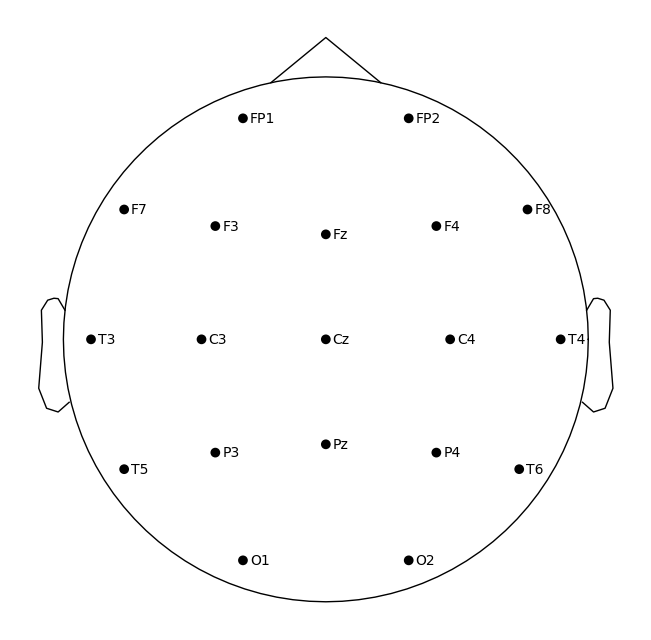

In [ ]:
import mne
import matplotlib.pyplot as plt
from mne.datasets import fetch_fsaverage

# Define EEG channel coordinates (example channels)
mtg_chan = {
    'FP1': [-0.03, 0.08, 0], 'FP2': [0.03, 0.08, 0],
    'F7': [-0.073, 0.047, 0], 'F3': [-0.04, 0.041, 0], 'Fz': [0, 0.038, 0],
    'F4': [0.04, 0.041, 0], 'F8': [0.073, 0.047, 0], 'T3': [-0.085, 0, 0],
    'C3': [-0.045, 0, 0], 'Cz': [0, 0, 0], 'C4': [0.045, 0, 0], 'T4': [0.085, 0, 0],
    'T5': [-0.073, -0.047, 0], 'P3': [-0.04, -0.041, 0], 'Pz': [0, -0.038, 0],
    'P4': [0.04, -0.041, 0], 'T6': [0.07, -0.047, 0], 'O1': [-0.03, -0.08, 0], 'O2': [0.03, -0.08, 0]
}

# Create MNE info object and montage
info = mne.create_info(list(mtg_chan.keys()), sfreq=500, ch_types='eeg')
montage = mne.channels.make_dig_montage(mtg_chan)
info.set_montage(montage)

# Create a plot of sensors overlaid on a head model (without using brain surface)
fig = mne.viz.plot_sensors(info, ch_type='eeg', show_names=True)

# Save the plot
fig.savefig('eeg_sensors_head_only.png', bbox_inches='tight', transparent=True)

# Display the plot (optional)
plt.show()
